# Dipole
This example reproduces the topology constraint.

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from quadcoil import quadcoil
from simsopt import load
from simsopt.field import CurrentPotentialFourier, CurrentPotentialSolve
import jax
import os
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import block_until_ready, devices, config
import time
devices()

[CudaDevice(id=0)]

## Loading files

In [2]:
# Loading muse++ equilibrium into VMEC
# filename_pp = "wout_muse++.nc"
# equil_pp = Vmec(filename_pp, keep_all_files=True)
# plasma_surface = equil_pp.boundary
# net_poloidal_current_amperes = equil_pp.external_current()

# Loading NCSX
winding_surface, plasma_surface = load('surfaces.json')
net_poloidal_current_amperes = 11884578.094260072
mpol = 4
ntor = 4
jax.config.update('jax_enable_x64', False)

# Problem settings

In [3]:
# Settings 
separation = 0.1
mpol = 12
ntor = 12
nfp = plasma_surface.nfp
plasma_M_theta = 16
plasma_N_phi = 32

## Running a REGCOIL scan

In [4]:
if not os.path.exists('regcoil.npy'):
    # We scan the REGCOIL regularization factor for choosing a 
    # point as comparison and for a taylor test later.
    f_B_test_list = []
    phi_test_list = []
    f_K_test_list = []
    time_quadcoil_list = []
    time_regcoil_list = []
    phi_ans_list = []
    f_B_ans_list = []
    f_K_ans_list = []
    for i in jnp.append(10**np.linspace(-10, -20, 20), 0.):
        # Run QUADCOIL first
        time1 = time.time()
        regcoili_out_dict, regcoili_qp, regcoil1_dofs, status = quadcoil(
            nfp=plasma_surface.nfp,
            stellsym=plasma_surface.stellsym,
            mpol=mpol,
            ntor=ntor,
            plasma_dofs=plasma_surface.get_dofs(),
            plasma_mpol=plasma_surface.mpol,
            plasma_ntor=plasma_surface.ntor,
            net_poloidal_current_amperes=net_poloidal_current_amperes,
            net_toroidal_current_amperes=0.,
            plasma_coil_distance=separation,
            objective_name=('f_B', 'f_K'),
            objective_weight=np.array([1., i]),
            objective_unit=(1., 1.),
            metric_name=('f_B', 'f_K'),
        )
    
        phi_test_list.append(regcoil1_dofs)
        f_B_test_list.append(regcoili_out_dict['f_B']['value'])
        f_K_test_list.append(regcoili_out_dict['f_K']['value'])
        time2 = time.time()
        time_quadcoil_list.append(time2-time1)
        print('i =', i, '| time =', time2-time1)
    
        wsi = regcoili_qp.winding_surface.to_simsopt()
        psi = regcoili_qp.plasma_surface.to_simsopt()
        cpi = CurrentPotentialFourier(
            wsi, mpol=mpol, ntor=ntor,
            net_poloidal_current_amperes=net_poloidal_current_amperes,
            net_toroidal_current_amperes=0.,
            stellsym=True)
        cpsti = CurrentPotentialSolve(cpi, psi, 0)
        regcoil1_dofs_ans, regcoili_f_B_ans, regcoili_f_K_ans = cpsti.solve_tikhonov(i)
        time2 = time.time()
        time_regcoil_list.append(time2-time1)
        phi_ans_list.append(regcoil1_dofs_ans)
        f_B_ans_list.append(regcoili_f_B_ans)
        f_K_ans_list.append(regcoili_f_K_ans)
        
    print('QUADCOIL avg time:', np.average(time_quadcoil_list), '(s)')
    print('QUADCOIL max time:', np.max(time_quadcoil_list), '(s)')
    print('REGCOIL avg time:', np.average(time_regcoil_list), '(s)')
    print('REGCOIL max time:', np.max(time_regcoil_list), '(s)')
    time_regcoil_list = np.array(time_regcoil_list)
    phi_ans_list = np.array(phi_ans_list)
    f_B_ans_list = np.array(f_B_ans_list)
    f_K_ans_list = np.array(f_K_ans_list)
    time_quadcoil_list = np.array(time_quadcoil_list)
    phi_test_list = np.array(phi_test_list)
    f_B_test_list = np.array(f_B_test_list)
    f_K_test_list = np.array(f_K_test_list)
    jnp.save('regcoil.npy',{
        'regcoili_qp': regcoili_qp,
        'time_regcoil_list': time_regcoil_list,
        'phi_ans_list': phi_ans_list,
        'f_B_ans_list': f_B_ans_list,
        'f_K_ans_list': f_K_ans_list,
        'time_quadcoil_list': time_quadcoil_list,
        'phi_test_list': phi_test_list,
        'f_B_test_list': f_B_test_list,
        'f_K_test_list': f_K_test_list,
    })
    # Is quadcoil really well-behaved than regcoil?
    print('Quadcoil seems to be more well-behaved than regcoil.')    
else:
    dict = jnp.load('regcoil.npy', allow_pickle=True).item()
    regcoili_qp = dict['regcoili_qp']
    time_regcoil_list = dict['time_regcoil_list']
    phi_ans_list = dict['phi_ans_list']
    f_B_ans_list = dict['f_B_ans_list']
    f_K_ans_list = dict['f_K_ans_list']
    time_quadcoil_list = dict['time_quadcoil_list']
    phi_test_list = dict['phi_test_list']
    f_B_test_list = dict['f_B_test_list']
    f_K_test_list = dict['f_K_test_list']

f_K at the inflection point: 27607928000000.0
f_B at the inflection point: 0.0010906216


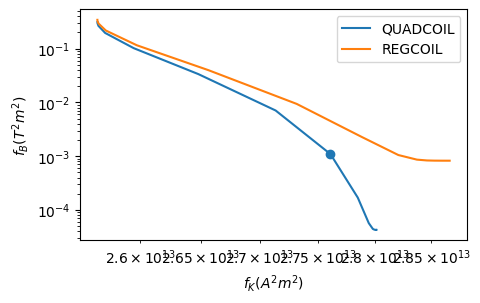

In [5]:
# inflection point
i_infl = 8 # np.argmin(f_K_test_list * f_B_test_list)
plt.figure(figsize=(5,3))
plt.plot(f_K_test_list, f_B_test_list, label='QUADCOIL')
plt.plot(f_K_ans_list, f_B_ans_list, label='REGCOIL')
plt.ylabel('$f_B(T^2m^2)$')
plt.xlabel('$f_K(A^2m^2)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.scatter(f_K_test_list[i_infl], f_B_test_list[i_infl])
print('f_K at the inflection point:', f_K_test_list[i_infl])
print('f_B at the inflection point:', f_B_test_list[i_infl])
f_B_target = f_B_test_list[i_infl]
phi_regcoil = phi_test_list[i_infl]

## Dipole layer thickness optimization
Here, we constrain the field error, and target the maximum 
magnitude of the dipole density over the surface.

The following block will appear to run slowly, but repeat them after one 
run and you'll notice a substantial speed-up. This is because JAX uses 
JIT-compilation.

In [6]:
# Calculating normalization factors
from quadcoil.quantity import f_max_Phi2, f_B, f_max_Phi, Phi, f_l1_Phi, f_max_Phi4
# Auto-normalization will not work for dipole objectives,
# because they are zero when Phi is 0.
# Therefore, we choose instead to normalize
# using the Phi measured from the inflection point.
unit_Phi2 = f_max_Phi2(regcoili_qp, phi_test_list[i_infl])
print('Max(Phi^2) =', unit_Phi2, 'At the inflection point.')
unit_Phi4 = f_max_Phi4(regcoili_qp, phi_test_list[i_infl])
print('Max(Phi^4) =', unit_Phi4, 'At the inflection point.')
unit_Phi = f_max_Phi(regcoili_qp, phi_test_list[i_infl])
print('Max(Phi) =', unit_Phi, 'At the inflection point.')
unit_l1 = f_l1_Phi(regcoili_qp, phi_test_list[i_infl])
print('||Phi||1) =', unit_l1, 'At the inflection point.')

Max(Phi^2) = 88781840000.0 At the inflection point.
Max(Phi^4) = 7.882215e+21 At the inflection point.
Max(Phi) = 297962.8 At the inflection point.
||Phi||1) = 2661558.8 At the inflection point.


In [7]:
time1=time.time()
# Solving with the quadcoil default function
out_dict, qp, dofs, status = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    plasma_coil_distance=separation,
    mpol=mpol,
    ntor=ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    metric_name='f_max_Phi',
    phi_init=phi_test_list[i_infl]['phi'],
    objective_name='f_max_Phi', # Minimizing peak dipole density
    objective_unit=unit_Phi, # under an f_B constraint
    constraint_name=('f_B',),
    constraint_type=('<=',),
    constraint_unit=(f_B_target,),
    constraint_value=np.array([f_B_target,]),
    # value_only=True,
)
jax.block_until_ready(dofs)
time2=time.time()
print('time:', time2-time1)

time: 19.812260627746582


In [8]:
time1=time.time()
# Solving using a different smoothing method
out_dict2, qp2, dofs2, status2 = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    plasma_coil_distance=separation,
    mpol=mpol,
    ntor=ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    metric_name='f_max_Phi',
    phi_init=phi_test_list[i_infl]['phi'],
    objective_name='f_max_Phi', # Minimizing peak dipole density
    objective_unit=unit_Phi, # under an f_B constraint
    constraint_name=('f_B',),
    constraint_type=('<=',),
    constraint_unit=(f_B_target,),
    constraint_value=np.array([f_B_target,]),
    # value_only=True,
    smoothing='approx'
)
jax.block_until_ready(dofs)
time2=time.time()
print('time:', time2-time1)

time: 17.01366925239563


f_B from REGCOIL:       0.0010906216
f_B from QUADCOIL:      0.0010906109
Max dipole dens from REGCOIL:            297962.8
Max dipole dens from QUADCOIL (slack)  : 269534.5 9.541 % improvement
Max dipole dens from QUADCOIL (softmax): 269677.06 9.493 % improvement


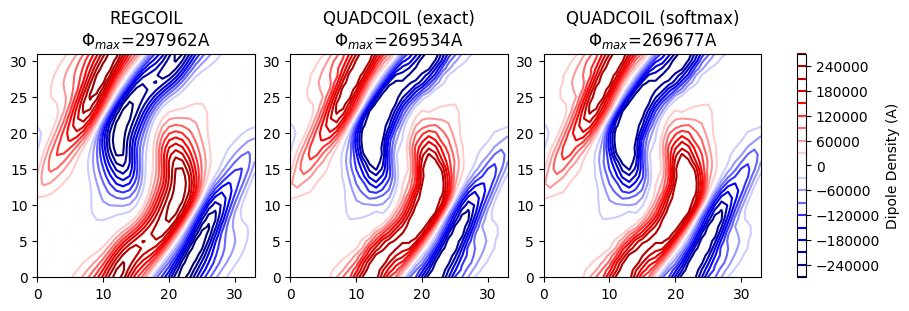

In [9]:
dofs_regcoil = phi_test_list[i_infl]
print('f_B from REGCOIL:      ', f_B(regcoili_qp, dofs_regcoil))
print('f_B from QUADCOIL:     ', f_B(qp, dofs))
f_Phi_ctrl = f_max_Phi(regcoili_qp,dofs_regcoil)
f_Phi_1 = f_max_Phi(qp, dofs)
f_Phi_2 = f_max_Phi(qp2, dofs2)
print('Max dipole dens from REGCOIL:           ', f_Phi_ctrl)
print('Max dipole dens from QUADCOIL (slack)  :', f_Phi_1, round((f_Phi_ctrl-f_Phi_1)/f_Phi_ctrl*100, 3), '% improvement')
print('Max dipole dens from QUADCOIL (softmax):', f_Phi_2, round((f_Phi_ctrl-f_Phi_2)/f_Phi_ctrl*100, 3), '% improvement')

phi_regcoil = Phi(qp, dofs_regcoil)
phi_quadcoil = Phi(qp, dofs)
phi_quadcoil2 = Phi(qp2, dofs2)
cmin = np.min([phi_regcoil, phi_quadcoil])
cmax = np.max([phi_regcoil, phi_quadcoil])

fig, axes = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)

# Plot for REGCOIL
im0 = axes[0].contour(phi_regcoil, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[0].set_title('REGCOIL\n'+r'$\Phi_{max}$='+str(int(f_Phi_ctrl))+'A')

# Plot for QUADCOIL
im1 = axes[1].contour(phi_quadcoil, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[1].set_title('QUADCOIL (exact)\n'+r'$\Phi_{max}$='+str(int(f_Phi_1))+'A')

# Plot for QUADCOIL
im1 = axes[2].contour(phi_quadcoil2, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[2].set_title('QUADCOIL (softmax)\n'+r'$\Phi_{max}$='+str(int(f_Phi_2))+'A')



# Add colorbar with better positioning
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', shrink=1., aspect=25, pad=0.05)
cbar.set_label("Dipole Density (A)")

plt.show()


## Dipole sparsity optimization
Here, we constrain the field error and maximum dipole density, 
and target the L-1 norm of the dipole over the surface.

In [10]:
f_Phi_ctrl = f_max_Phi(regcoili_qp, phi_test_list[i_infl])

In [14]:
# Solving with the quadcoil default function
time1 = time.time()
l1_out_dict, l1_qp, l1_dofs, l1_status = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    plasma_coil_distance=separation,
    mpol=mpol,
    ntor=ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    metric_name='f_B',
    objective_name='f_l1_Phi', # Minimizing the L1 norm of Phi
    objective_unit=unit_l1, # under an f_B, max Phi constraint
    constraint_name=('f_B', 'f_max_Phi',),
    constraint_type=('<=', '<=',),
    constraint_unit=(f_B_target, f_Phi_ctrl,),
    constraint_value=np.array([f_B_target, f_Phi_ctrl,]),
    value_only=True,
    # verbose=3,
    # **numerical_kwargs
)
time2 = time.time()
print(time2-time1)

1.9205691814422607


In [13]:
# Solving with softmax amoothing
time1 = time.time()
l1_out_dict2, l1_qp2, l1_dofs2, l1_status2 = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    plasma_coil_distance=separation,
    mpol=mpol,
    ntor=ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    metric_name='f_B',
    objective_name='f_l1_Phi', # Minimizing the L1 norm of Phi
    objective_unit=unit_l1, # under an f_B, max Phi constraint
    constraint_name=('f_B', 'f_max_Phi',),
    constraint_type=('<=', '<=',),
    constraint_unit=(f_B_target, f_Phi_ctrl,),
    constraint_value=np.array([f_B_target, f_Phi_ctrl,]),
    value_only=True,
    smoothing='approx'
    # verbose=3,
    # **numerical_kwargs
)
time2 = time.time()
print(time2-time1)

0.36459803581237793


f_B from REGCOIL:            0.0010906216
f_B from QUADCOIL (slack):   0.0010906215
f_B from QUADCOIL (softmax): 0.0010906323
Max L-1 norm from REGCOIL:             2661558.8
Max L-1 norm from QUADCOIL: (slack):   2456822.5 7.6920004 % improvement
Max L-1 norm from QUADCOIL: (softmax): 2456920.0 7.689 % improvement


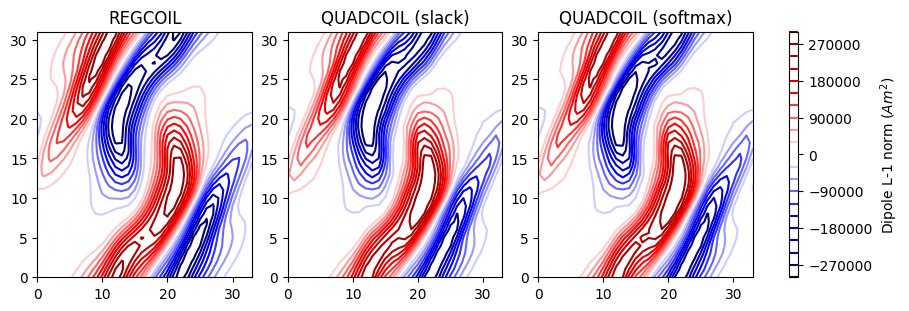

In [20]:
print('f_B from REGCOIL:           ', f_B(regcoili_qp, phi_test_list[i_infl]))
print('f_B from QUADCOIL (slack):  ', f_B(l1_qp, l1_dofs))
print('f_B from QUADCOIL (softmax):', f_B(l1_qp2, l1_dofs2))

f_l1_Phi_crtl = f_l1_Phi(regcoili_qp, phi_test_list[i_infl])
f_l1_Phi_l1 = f_l1_Phi(l1_qp, l1_dofs)
f_l1_Phi_l12 = f_l1_Phi(l1_qp2, l1_dofs2)

print('Max L-1 norm from REGCOIL:            ', f_l1_Phi_crtl)
print('Max L-1 norm from QUADCOIL: (slack):  ', f_l1_Phi_l1, round((f_l1_Phi_crtl-f_l1_Phi_l1)/f_l1_Phi_crtl*100, 3), '% improvement')
print('Max L-1 norm from QUADCOIL: (softmax):', f_l1_Phi_l12, round((f_l1_Phi_crtl-f_l1_Phi_l12)/f_l1_Phi_crtl*100, 3), '% improvement')

phi_regcoil = Phi(regcoili_qp, phi_test_list[i_infl])
phi_quadcoil_l1 = Phi(l1_qp, l1_dofs)
phi_quadcoil_l12 = Phi(l1_qp2, l1_dofs2)

cmin = np.min([phi_regcoil, phi_quadcoil_l1])
cmax = np.max([phi_regcoil, phi_quadcoil_l1])

fig, axes = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)

# Plot for REGCOIL
im0 = axes[0].contour(phi_regcoil, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[0].set_title('REGCOIL')

# Plot for QUADCOIL
im1 = axes[1].contour(phi_quadcoil_l1, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[1].set_title('QUADCOIL (slack)')

# Plot for QUADCOIL
im1 = axes[2].contour(phi_quadcoil_l12, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[2].set_title('QUADCOIL (softmax)')



# Add colorbar with better positioning
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', shrink=1., aspect=25, pad=0.05)
cbar.set_label("Dipole L-1 norm ($Am^2$)")

plt.show()


### Cumulative distribution function plot
This plot shows the proportion of grid points 
with dipole density $\leq x\% \Phi_{max}$.

<>:23: SyntaxWarning: invalid escape sequence '\P'
<>:24: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\P'
<>:24: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_73067/1981628759.py:23: SyntaxWarning: invalid escape sequence '\P'
  plt.xlabel('Dipole density, as % of $\Phi_{max}$ (A)')
/tmp/ipykernel_73067/1981628759.py:24: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('CDF (% $\leq$ x)')


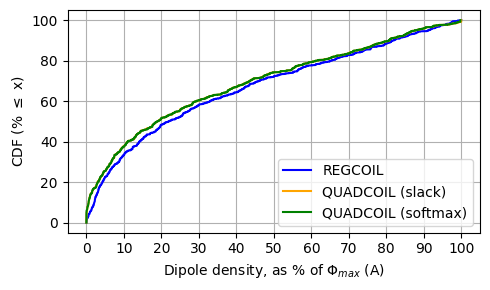

In [21]:

# Flatten arrays
phi_reg = jnp.abs(phi_regcoil.flatten())
phi_quad = jnp.abs(phi_quadcoil_l1.flatten())
phi_quad2 = jnp.abs(phi_quadcoil_l12.flatten())

# Sort values
phi_reg_sorted = np.sort(phi_reg) / np.max(phi_reg) * 100
phi_quad_sorted = np.sort(phi_quad) / np.max(phi_reg) *100
phi_quad_sorted2 = np.sort(phi_quad2) / np.max(phi_reg) *100

# Compute CCDFs
ccdf_reg = np.arange(1, len(phi_reg_sorted)+1) / len(phi_reg_sorted)*100
ccdf_quad = np.arange(1, len(phi_quad_sorted)+1) / len(phi_quad_sorted)*100
ccdf_quad2 = np.arange(1, len(phi_quad_sorted2)+1) / len(phi_quad_sorted2)*100

# Plot
plt.figure(figsize=(5, 3))
plt.plot(phi_reg_sorted, ccdf_reg, label='REGCOIL', color='blue')
plt.plot(phi_quad_sorted, ccdf_quad, label='QUADCOIL (slack)', color='orange')
plt.plot(phi_quad_sorted2, ccdf_quad2, label='QUADCOIL (softmax)', color='green')
plt.xticks(np.linspace(0, 100, 11))
# Labels and legend
plt.xlabel('Dipole density, as % of $\Phi_{max}$ (A)')
plt.ylabel('CDF (% $\leq$ x)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()